### Regression and Classification Based On Indicators:

- Classifier Model: Price increasing [1;0] or decreasing [0;1]
- Regression Model: Predict next trading day price


### Weekly Goal: 

1. VWAP_mean[y_pred] change to reurn_label
2. Strategy_return should based on model buit
3. Save the model for 324 before y_pred. And get the y then do y_pred, strategy_return, cumsum, cumprod
4. Continue, --- rmse, range of error, /categorical --- repot_metrics. standerd, f1/
5. x, TIME(T) , Y (T+1) --- take x giving what you know about x to predict y (10 second later)

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
import pprint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mpl


%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# install pydrive to load data
#!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id = "1_71asScU8XI31EIcWF_ikPj0ihvcgfOu"  
file = drive.CreateFile({'id':id}) 
file.GetContentFile('DOW20200323') 

id = "1raZfnsw8fsxxHQ5e5oFIM-zmmXiiWKCX"  
file = drive.CreateFile({'id':id}) 
file.GetContentFile('DOW20200324') 

In [4]:
import pandas as pd

dow_324 = pd.read_csv('DOW20200324')
dow_323 = pd.read_csv('DOW20200323')
dow_323.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78070 entries, 0 to 78069
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          78070 non-null  object 
 1   timestamp       78070 non-null  object 
 2   bid_price       74723 non-null  float64
 3   bid_size        74723 non-null  float64
 4   bid_price_lag   74723 non-null  float64
 5   bid_size_lag    74723 non-null  float64
 6   V_of_B          74723 non-null  float64
 7   ask_price       74723 non-null  float64
 8   ask_size        74723 non-null  float64
 9   ask_price_lag   74723 non-null  float64
 10  ask_size_lag    74723 non-null  float64
 11  V_of_A          74723 non-null  float64
 12  VOI             74723 non-null  float64
 13  OIR             74723 non-null  float64
 14  bid_ask_spread  74723 non-null  float64
 15  VWAP_max        77455 non-null  float64
 16  VWAP_mean       77455 non-null  float64
 17  VWAP_min        77455 non-null 

In [5]:
dow_323.shape

(78070, 26)

In [6]:
dow_323.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78070 entries, 0 to 78069
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          78070 non-null  object 
 1   timestamp       78070 non-null  object 
 2   bid_price       74723 non-null  float64
 3   bid_size        74723 non-null  float64
 4   bid_price_lag   74723 non-null  float64
 5   bid_size_lag    74723 non-null  float64
 6   V_of_B          74723 non-null  float64
 7   ask_price       74723 non-null  float64
 8   ask_size        74723 non-null  float64
 9   ask_price_lag   74723 non-null  float64
 10  ask_size_lag    74723 non-null  float64
 11  V_of_A          74723 non-null  float64
 12  VOI             74723 non-null  float64
 13  OIR             74723 non-null  float64
 14  bid_ask_spread  74723 non-null  float64
 15  VWAP_max        77455 non-null  float64
 16  VWAP_mean       77455 non-null  float64
 17  VWAP_min        77455 non-null 

In [7]:
dow_323 = dow_323.replace([np.inf, -np.inf], np.nan)
dow_324 = dow_324.replace([np.inf, -np.inf], np.nan)

### Features pre-processing:
1. Convert VWAP_Mean to Percentage change
2. Change 'VWAP_Mean' to 'Returen'
3. Keep VOI, OIR, bid_ask_spread, EWM, RSI, OBV

In [8]:
#1. Convert VWAP_Mean to Percentage change
# we use the forward fill method to 
# fill the missing values in the dataframe 
dow_323['vwap_next10s'] = dow_323['VWAP_mean'].shift(-1)

In [9]:
dow_324['vwap_next10s'] = dow_324['VWAP_mean'].shift(-1)

In [10]:
dow_323['diff'] = dow_323['vwap_next10s'] - dow_323['VWAP_mean']
dow_324['diff'] = dow_324['vwap_next10s'] - dow_324['VWAP_mean']

In [11]:
#if prediction>0, signal is 1, otherwise -1
dow_323['return_label'] = dow_323['diff'].apply(lambda x: 1 if x>0 else -1)
dow_324['return_label'] = dow_324['diff'].apply(lambda x: 1 if x>0 else -1)

In [12]:
#dow_323.head(20)

In [13]:
dow_323.describe([0.05, 0.08, 0.1, 0.95,0.96,0.97,0.98])

,bid_price,bid_size,bid_price_lag,bid_size_lag,V_of_B,ask_price,ask_size,ask_price_lag,ask_size_lag,V_of_A,VOI,OIR,bid_ask_spread,VWAP_max,VWAP_mean,VWAP_min,size_mean,EWM,RSI,Stochastic,WilliamsR,MACD,Signal_line,OBV,vwap_next10s,diff,return_label
count,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,74723.000000,77455.000000,77455.000000,77455.000000,77455.000000,77455.000000,63955.000000,6.455900e+04,6.455900e+04,77455.000000,77455.000000,78070.000000,77454.000000,77447.000000,78070.000000
mean,93.412821,112.454920,-0.002601,-0.028586,14.588333,94.231701,105.392249,0.000792,-0.220173,9.020877,5.567456,0.043119,0.818880,95.260728,95.256918,95.253042,54.182339,94.555297,33.973969,3.513843e+01,-6.486157e+01,-0.017311,-0.017305,-7.830317,95.255165,-0.001917,-0.737646
std,50.846258,395.273779,1.219997,417.260809,292.771157,51.416378,362.328895,1.672197,263.353071,97.777248,306.617191,0.636003,6.730268,52.178345,52.174358,52.170415,83.897781,51.692163,45.956916,4.401365e+01,4.401365e+01,0.193553,0.185812,75.301185,52.172414,1.330974,0.675192
min,21.800000,0.000000,-199.930000,-71206.000000,-7873.000000,26.270000,0.000000,-217.710000,-39363.000000,-8613.000000,-8513.000000,-1.000000,-6.210000,26.210000,26.117778,25.933333,0.000000,26.095461,0.000000,-5.434134e-10,-1.000000e+02,-3.807692,-3.412256,-4399.000000,26.117778,-139.960715,-1.000000
5%,28.590000,0.000000,-0.080000,-75.000000,0.000000,28.660000,0.000000,-0.100000,0.000000,0.000000,-100.000000,-1.000000,-0.690000,28.644865,28.644712,28.644342,0.000000,28.715550,0.000000,0.000000e+00,-1.000000e+02,-0.096779,-0.097993,-99.000000,28.644710,-0.006063,-1.000000
8%,30.980000,0.000000,-0.030000,0.000000,0.000000,31.010000,0.000000,-0.030000,0.000000,0.000000,-100.000000,-1.000000,-0.470000,30.942609,30.942590,30.942590,0.000000,31.032694,0.000000,0.000000e+00,-1.000000e+02,-0.058876,-0.059299,-77.028860,30.942590,-0.003245,-1.000000
10%,32.360000,0.000000,-0.010000,0.000000,0.000000,33.150000,0.000000,-0.020000,0.000000,0.000000,0.000000,-1.000000,-0.370000,33.125000,33.125000,33.125000,0.000000,33.126341,0.000000,0.000000e+00,-1.000000e+02,-0.047766,-0.047877,-61.500000,33.125000,-0.002036,-1.000000
50%,89.300000,100.000000,0.000000,0.000000,0.000000,89.920000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060000,89.766001,89.766001,89.765975,50.000000,90.003596,0.000000,4.285966e+00,-9.571403e+01,-0.002781,-0.002841,1.000000,89.766001,0.000000,-1.000000
95%,195.730000,300.000000,0.080000,35.800000,100.000000,196.150000,208.000000,0.070000,0.000000,100.000000,100.000000,1.000000,2.590000,200.746038,200.746038,200.714573,100.000000,197.283386,100.000000,1.000000e+02,-0.000000e+00,0.040754,0.041236,67.666667,200.738636,0.001302,1.000000
96%,199.170000,300.000000,0.110000,100.000000,100.000000,200.310000,300.000000,0.110000,100.000000,100.000000,100.000000,1.000000,3.670000,220.086594,220.086594,220.086594,121.750000,213.741288,100.000000,1.000000e+02,-0.000000e+00,0.052131,0.052113,82.068539,220.086594,0.001855,1.000000


In [14]:
check_corr = dow_323.loc[:, ["symbol", "timestamp", "VOI","OIR","bid_ask_spread","EWM","OBV","return_label"]]

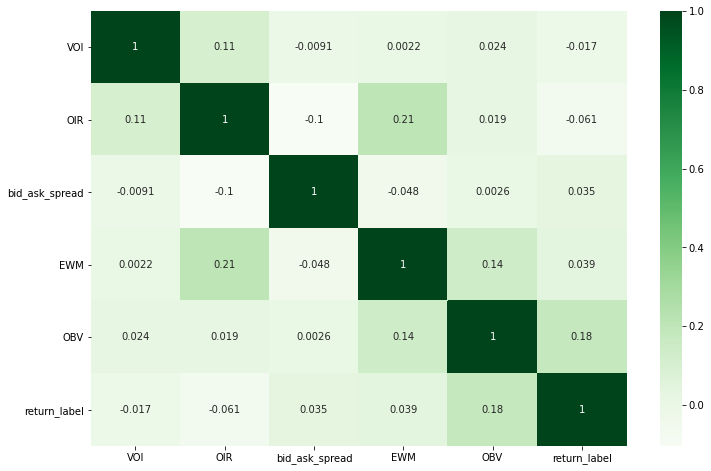

In [15]:
# Check correlation
import seaborn as sns
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(check_corr[check_corr['symbol'] == 'AAPL'].corr(),ax=ax,annot=True,cmap='Greens');

In [16]:
dow_323 = dow_323.loc[:, ["symbol", "timestamp", "VOI", "OIR", "bid_ask_spread", "EWM", "OBV", "VWAP_mean", "return_label"]]
dow_324 = dow_324.loc[:, ["symbol", "timestamp", "VOI", "OIR", "bid_ask_spread", "EWM", "OBV", "VWAP_mean", "return_label", "diff"]]

In [17]:
dow_323 = dow_323.dropna()
dow_324 = dow_324.dropna()

### Data Preprocessing: 2~3 tickers (Prediction data 1 day: dow_323)

In [18]:
df_aapl = dow_323[dow_323['symbol'] == 'AAPL'] #Tech
df_wmt = dow_323[dow_323['symbol'] == 'WMT']  #retail
df_jnj = dow_323[dow_323['symbol'] == 'JNJ']  #pharmaceutical

In [19]:
df_aapl_324 = dow_324[dow_324['symbol'] == 'AAPL'] #Tech
df_wmt_324 = dow_324[dow_324['symbol'] == 'WMT']  #retail
df_jnj_324 = dow_324[dow_324['symbol'] == 'JNJ']  #pharmaceutical

## Classification: RandomForestClassification/ Logistic Regression/ SVC

In [20]:
#libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [21]:
y= df_aapl["return_label"]
X= df_aapl.drop(columns=["symbol","timestamp","return_label", "VWAP_mean"], axis=1)

In [22]:
scaler = StandardScaler()
X_scale = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [23]:
rfc = RandomForestClassifier(random_state=42)


parameters = {'n_estimators': np.arange(50,300,50)}

rfc_ = GridSearchCV(rfc, parameters)
rfc_.fit(X_scale, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                               

In [24]:
rfc_.best_params_

{'n_estimators': 50}

In [25]:
y_test = df_aapl_324["return_label"]
X_test = df_aapl_324.drop(columns=["symbol", "timestamp", "return_label", "VWAP_mean", "diff"], axis=1)

In [26]:
y_pred = rfc_.predict(X_test)

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.75      0.03      0.05      1782
           1       0.24      0.97      0.39       574

    accuracy                           0.26      2356
   macro avg       0.50      0.50      0.22      2356
weighted avg       0.63      0.26      0.13      2356



In [28]:
print(accuracy_score(y_test, y_pred))

0.2567911714770798


### KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()


parameters1 = {'n_neighbors': np.arange(1,10),
               'leaf_size': [25,30,35,40]}

knn_grid = GridSearchCV(knn, parameters1)
knn_grid.fit(X_scale, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'leaf_size': [25, 30, 35, 40],
                         'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [35]:
knn_grid.best_params_

{'leaf_size': 35, 'n_neighbors': 8}

In [36]:
knn_grid.score(X_test, y_test)

0.682937181663837

In [37]:
y_pred_knn = knn_grid.predict(X_test)

In [38]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

          -1       0.79      0.79      0.79      1782
           1       0.35      0.36      0.36       574

    accuracy                           0.68      2356
   macro avg       0.57      0.57      0.57      2356
weighted avg       0.69      0.68      0.68      2356



### SVC

In [39]:
from sklearn.svm import SVC

svc = SVC()

parameters2 = {'C': np.arange(1, 20)}

svc_grid = GridSearchCV(svc, parameters2)
svc_grid.fit(X_scale, y)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [40]:
svc_grid.best_params_

{'C': 1}

In [41]:
svc_grid.score(X_test, y_test)

0.7563667232597623

In [42]:
y_pred_svc = svc_grid.predict(X_test)

In [43]:
print(classification_report(y_test,y_pred_svc))

              precision    recall  f1-score   support

          -1       0.76      1.00      0.86      1782
           1       0.00      0.00      0.00       574

    accuracy                           0.76      2356
   macro avg       0.38      0.50      0.43      2356
weighted avg       0.57      0.76      0.65      2356



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


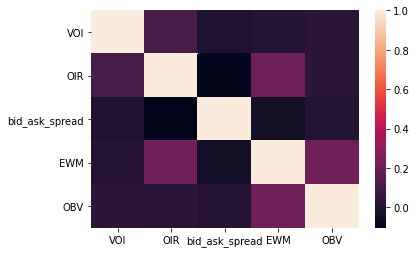

In [44]:
import seaborn as sns
sns.heatmap(X_scale.corr())

### Visualization: Prediction
- https://blog.quantinsti.com/machine-learning-classification-strategy-python/

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

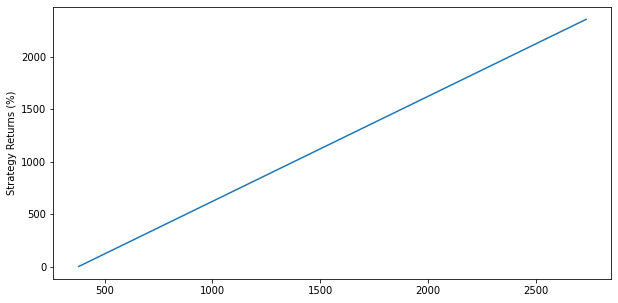

In [45]:
df_aapl_324['Predicted_Signal'] = svc_grid.predict(X_test)
# Calculate log returns
df_aapl_324['Return'] = df_aapl_324['VWAP_mean'].pct_change().shift(-1)
df_aapl_324['Strategy_Return'] = df_aapl_324['Return'] * df_aapl_324['Predicted_Signal']
(1+ df_aapl_324['Strategy_Return']).cumsum().plot(figsize=(10,5))
#(1+ df_aapl_324['Strategy_Return']).cumprod().plot()
plt.ylabel("Strategy Returns (%)")
plt.show()

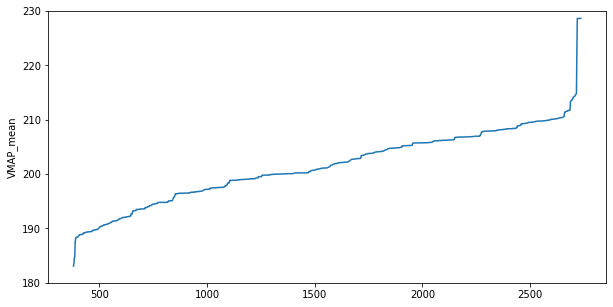

In [46]:
df_aapl_324.VWAP_mean.plot(figsize=(10,5))
plt.ylabel("VMAP_mean")
plt.ylim(180, 230)
plt.show()